In [1]:
from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm
 
import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random



[2024-02-26 20:27:24] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
[2024-02-26 20:27:24] WARNING - __init__.py - Failed to import pytorch_quantization


The console stream is logged into /home/sjhjrol/sg_logs/console.log


[2024-02-26 20:27:26] WARNING - calibrator.py - Failed to import pytorch_quantization
[2024-02-26 20:27:26] WARNING - export.py - Failed to import pytorch_quantization
[2024-02-26 20:27:26] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


In [2]:
import json
import os


# Ensure the label directory exists
def create_labels(coco_json_path,label_dir):
    os.makedirs(label_dir, exist_ok=True)
    os.makedirs(label_dir+"/data/",exist_ok=True)
    # Load COCO JSON annotations
    with open(coco_json_path, 'r') as f:
        coco_data = json.load(f)

    # Function to convert COCO bounding box to YOLO format
    def coco_to_yolo(bbox, img_width, img_height):
        x_center = bbox[0] + bbox[2] / 2
        y_center = bbox[1] + bbox[3] / 2
        width = bbox[2]
        height = bbox[3]
        # Normalize coordinates
        return x_center / img_width, y_center / img_height, width / img_width, height / img_height

    # Create a dictionary to map image IDs to file names
    image_id_to_filename = {img['id']: img['file_name'] for img in coco_data['images']}
    print(image_id_to_filename)
    # Create a dictionary to map category IDs to their YOLO class ID (index)
    category_id_to_class_id = {cat['id']: idx for idx, cat in enumerate(coco_data['categories'])}

    # Process annotations
    for annotation in coco_data['annotations']:
        image_id = annotation['image_id']
        category_id = annotation['category_id']
        bbox = annotation['bbox']
        
        # Find corresponding image filename and dimensions
        image_filename = image_id_to_filename[image_id]
        img_width = next(img['width'] for img in coco_data['images'] if img['id'] == image_id)
        img_height = next(img['height'] for img in coco_data['images'] if img['id'] == image_id)
        
        # Convert COCO bbox format to YOLO format
        yolo_bbox = coco_to_yolo(bbox, img_width, img_height)
        
        # Get YOLO class ID
        class_id = category_id_to_class_id[category_id]
        
        # Create label file path
        label_file_path = os.path.join(label_dir, os.path.splitext(image_filename)[0] + '.txt')
        
        # Append annotation to label file
        with open(label_file_path, 'a') as label_file:
            label_file.write(f"{class_id} {' '.join(map(str, yolo_bbox))}\n")

    print("Label files creation completed.")


In [3]:
# Path to your COCO JSON file
coco_json_path = './FLIR_ADAS_v2/images_thermal_train/coco.json'
# Directory where you want to save the label files
label_dir = './FLIR_ADAS_v2/images_thermal_train/labels'
create_labels(coco_json_path,label_dir)
# Path to your COCO JSON file
coco_json_path = './FLIR_ADAS_v2/images_thermal_val/coco.json'
# Directory where you want to save the label files
label_dir = './FLIR_ADAS_v2/images_thermal_val/labels'
create_labels(coco_json_path,label_dir)
# Path to your COCO JSON file
coco_json_path = './FLIR_ADAS_v2/video_thermal_test/coco.json'
# Directory where you want to save the label files
label_dir = './FLIR_ADAS_v2/video_thermal_test/labels'
create_labels(coco_json_path,label_dir)


/home/sjhjrol/anaconda3/envs/flir/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


{0: 'data/video-GzdKTLbkG5F7gAunM-frame-000108-QHZmA4QTZCnzBG3HZ.jpg', 1: 'data/video-GzdKTLbkG5F7gAunM-frame-000123-zT9WiGpogNTW2duPu.jpg', 2: 'data/video-GzdKTLbkG5F7gAunM-frame-000138-hGJXmoECsAKraavzR.jpg', 3: 'data/video-GzdKTLbkG5F7gAunM-frame-000153-CLf3aejSKSCNt94Aw.jpg', 4: 'data/video-GzdKTLbkG5F7gAunM-frame-000168-T6ecK2ACpL8zQCKwL.jpg', 5: 'data/video-GzdKTLbkG5F7gAunM-frame-000284-v68F7QyxkFbbGqgzg.jpg', 6: 'data/video-GzdKTLbkG5F7gAunM-frame-000299-ZteJGSdeWHa5yH2vx.jpg', 7: 'data/video-GzdKTLbkG5F7gAunM-frame-000314-eX5pi3pcXMkXDivrC.jpg', 8: 'data/video-GzdKTLbkG5F7gAunM-frame-000329-CvNDA6nRRHaphYaCg.jpg', 9: 'data/video-GzdKTLbkG5F7gAunM-frame-000344-TM4zrDbGGHafGD5ew.jpg', 10: 'data/video-GzdKTLbkG5F7gAunM-frame-000359-FZJ62yuucEZeTisfB.jpg', 11: 'data/video-GzdKTLbkG5F7gAunM-frame-000374-vkJ8c96xNDdEwqAEZ.jpg', 12: 'data/video-GzdKTLbkG5F7gAunM-frame-000389-xNBEaFoPwygS6ykzS.jpg', 13: 'data/video-GzdKTLbkG5F7gAunM-frame-000404-e8cCWh4sF25XyHuwz.jpg', 14: 'data/video

In [4]:
ROOT_DIR = './FLIR_ADAS_v2'
train_imgs_dir = 'images_thermal_train/data'
train_labels_dir = 'images_thermal_train/labels/data'
val_imgs_dir = 'images_thermal_val/data'
val_labels_dir = 'images_thermal_val/labels/data'
test_imgs_dir = 'images_thermal_test/data'
test_labels_dir = 'images_thermal_test/labels/data'
classes = ['Person', 'Car', 'Bicycle', 'OtherVechicle', 'DontCare']
 
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes 
}



In [5]:
# Global parameters.
EPOCHS = 50
BATCH_SIZE = 16
WORKERS = 8

In [6]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)
 
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

[2024-02-26 20:28:42] WARNING - yolo_format_detection.py - 264 images are note associated to any label file
[2024-02-26 20:28:42] WARNING - yolo_format_detection.py - As a consequence, 10478/10742 images and 10478/10478 label files will be used.
[2024-02-26 20:28:42] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 10478/10478 [00:01<00:00, 5892.52it/s]
[2024-02-26 20:28:43] WARNING - detection_dataset.py - Found 170344 invalid bbox that were ignored. For more information, please set `show_all_warnings=True`.
[2024-02-26 20:28:43] WARNING - yolo_format_detection.py - 16 images are note associated to any label file
[2024-02-26 20:28:43] WARNING - yolo_format_detection.py - As a consequence, 1128/1144 images and 1128/1128 label files will be used.
[2024-02-26 20:28:43] INFO - detection_dataset.py - Dataset Initialization in progress. `ca

Label files creation completed.


In [7]:
train_data.dataset.transforms

In [8]:
train_data.dataset.transforms.pop(2)




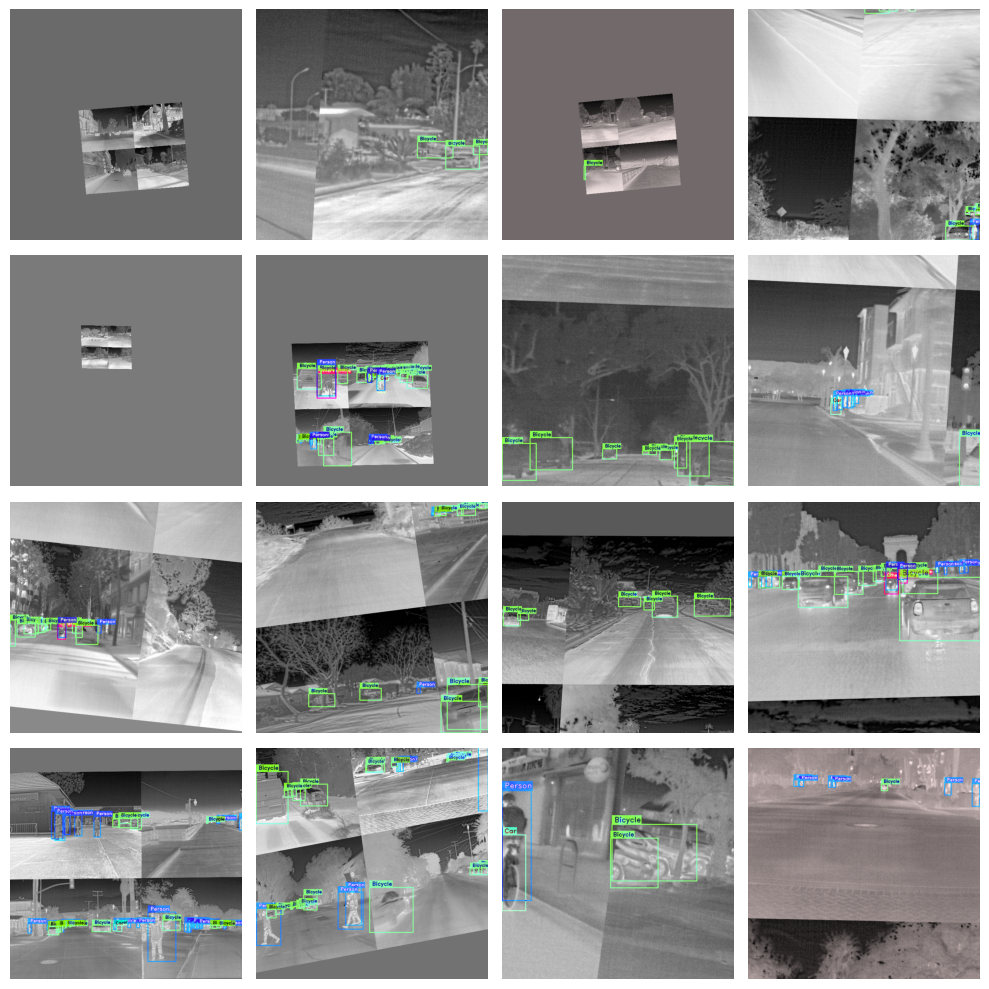

In [9]:
train_data.dataset.plot(plot_transformed_data=True)

In [10]:
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

In [11]:
models_to_train = [
    'yolo_nas_s'
]
#    'yolo_nas_m',
#    'yolo_nas_l'
#]
 
CHECKPOINT_DIR = 'checkpoints'
 
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train, 
        ckpt_root_dir=CHECKPOINT_DIR
    )
 
    model = models.get(
        model_to_train, 
        num_classes=len(dataset_params['classes']), 
        pretrained_weights="coco"
    )
 
    trainer.train(
        model=model, 
        training_params=train_params, 
        train_loader=train_data, 
        valid_loader=val_data
    )

[2024-02-26 20:28:46] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-02-26 20:28:46] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_s
[2024-02-26 20:28:46] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20240226_202846_537777`
[2024-02-26 20:28:46] INFO - sg_trainer.py - Checkpoints directory: checkpoints/yolo_nas_s/RUN_20240226_202846_537777
[2024-02-26 20:28:46] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to checkpoints/yolo_nas_s/RUN_20240226_202846_537777/console_Feb26_20_28_46.txt


/home/sjhjrol/anaconda3/envs/flir/lib/python3.9/site-packages/super_gradients/common/registry/registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
/home/sjhjrol/anaconda3/envs/flir/lib/python3.9/site-packages/super_gradients/training/utils/optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of layer name prefixes to lr values through initial_lr training hyperparameter (i.e initial_lr={'backbone': 0.01, 'default':0.1})
  warnings.warn(
[2024-02-26 20:28:49] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 availa

SUMMARY OF EPOCH 0
├── Train
│   ├── Ppyoloeloss/loss_cls = 1.888
│   ├── Ppyoloeloss/loss_iou = 0.7769
│   ├── Ppyoloeloss/loss_dfl = 0.5017
│   └── Ppyoloeloss/loss = 3.1666
└── Validation
    ├── Ppyoloeloss/loss_cls = 1.1596
    ├── Ppyoloeloss/loss_iou = 0.6438
    ├── Ppyoloeloss/loss_dfl = 0.3865
    ├── Ppyoloeloss/loss = 2.1899
    ├── Precision@0.50 = 0.0661
    ├── Recall@0.50 = 0.129
    ├── Map@0.50 = 0.067
    ├── F1@0.50 = 0.0865
    ├── Best_score_threshold = 0.2
    ├── Precision@0.50:0.95 = 0.0272
    ├── Recall@0.50:0.95 = 0.0535
    ├── Map@0.50:0.95 = 0.027
    └── F1@0.50:0.95 = 0.0358



Validating epoch 1: 100%|██████████| 69/69 [00:33<00:00,  2.05it/s]
[2024-02-26 20:33:20] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 20:33:20] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.10203772783279419


SUMMARY OF EPOCH 1
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.8139
│   │   ├── Epoch N-1      = 1.888  (↘ -1.074)
│   │   └── Best until now = 1.888  (↘ -1.074)
│   ├── Ppyoloeloss/loss_iou = 0.5536
│   │   ├── Epoch N-1      = 0.7769 (↘ -0.2233)
│   │   └── Best until now = 0.7769 (↘ -0.2233)
│   ├── Ppyoloeloss/loss_dfl = 0.4066
│   │   ├── Epoch N-1      = 0.5017 (↘ -0.0951)
│   │   └── Best until now = 0.5017 (↘ -0.0951)
│   └── Ppyoloeloss/loss = 1.7742
│       ├── Epoch N-1      = 3.1666 (↘ -1.3925)
│       └── Best until now = 3.1666 (↘ -1.3925)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7335
    │   ├── Epoch N-1      = 1.1596 (↘ -0.4262)
    │   └── Best until now = 1.1596 (↘ -0.4262)
    ├── Ppyoloeloss/loss_iou = 0.5589
    │   ├── Epoch N-1      = 0.6438 (↘ -0.0848)
    │   └── Best until now = 0.6438 (↘ -0.0848)
    ├── Ppyoloeloss/loss_dfl = 0.3984
    │   ├── Epoch N-1      = 0.3865 (↗ 0.0119)
    │   └── Best until now = 0.3865 (↗ 0.0119)
    ├── Ppyoloeloss/loss =

Validating epoch 2: 100%|██████████| 69/69 [00:34<00:00,  2.01it/s]
[2024-02-26 20:35:38] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 20:35:38] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.11011554300785065


SUMMARY OF EPOCH 2
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7773
│   │   ├── Epoch N-1      = 0.8139 (↘ -0.0367)
│   │   └── Best until now = 0.8139 (↘ -0.0367)
│   ├── Ppyoloeloss/loss_iou = 0.5342
│   │   ├── Epoch N-1      = 0.5536 (↘ -0.0194)
│   │   └── Best until now = 0.5536 (↘ -0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.4081
│   │   ├── Epoch N-1      = 0.4066 (↗ 0.0015)
│   │   └── Best until now = 0.4066 (↗ 0.0015)
│   └── Ppyoloeloss/loss = 1.7196
│       ├── Epoch N-1      = 1.7742 (↘ -0.0546)
│       └── Best until now = 1.7742 (↘ -0.0546)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7141
    │   ├── Epoch N-1      = 0.7335 (↘ -0.0193)
    │   └── Best until now = 0.7335 (↘ -0.0193)
    ├── Ppyoloeloss/loss_iou = 0.5002
    │   ├── Epoch N-1      = 0.5589 (↘ -0.0588)
    │   └── Best until now = 0.5589 (↘ -0.0588)
    ├── Ppyoloeloss/loss_dfl = 0.3835
    │   ├── Epoch N-1      = 0.3984 (↘ -0.0149)
    │   └── Best until now = 0.3865 (↘ -0.003)
    ├── Ppyoloeloss/loss 

Validating epoch 3: 100%|██████████| 69/69 [00:34<00:00,  2.00it/s]
[2024-02-26 20:38:01] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 20:38:01] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.11455397307872772


SUMMARY OF EPOCH 3
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7743
│   │   ├── Epoch N-1      = 0.7773 (↘ -0.003)
│   │   └── Best until now = 0.7773 (↘ -0.003)
│   ├── Ppyoloeloss/loss_iou = 0.5317
│   │   ├── Epoch N-1      = 0.5342 (↘ -0.0025)
│   │   └── Best until now = 0.5342 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_dfl = 0.4101
│   │   ├── Epoch N-1      = 0.4081 (↗ 0.002)
│   │   └── Best until now = 0.4066 (↗ 0.0035)
│   └── Ppyoloeloss/loss = 1.7161
│       ├── Epoch N-1      = 1.7196 (↘ -0.0035)
│       └── Best until now = 1.7196 (↘ -0.0035)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7172
    │   ├── Epoch N-1      = 0.7141 (↗ 0.0031)
    │   └── Best until now = 0.7141 (↗ 0.0031)
    ├── Ppyoloeloss/loss_iou = 0.5128
    │   ├── Epoch N-1      = 0.5002 (↗ 0.0126)
    │   └── Best until now = 0.5002 (↗ 0.0126)
    ├── Ppyoloeloss/loss_dfl = 0.3937
    │   ├── Epoch N-1      = 0.3835 (↗ 0.0102)
    │   └── Best until now = 0.3835 (↗ 0.0102)
    ├── Ppyoloeloss/loss = 1.6237

Validating epoch 4: 100%|██████████| 69/69 [00:34<00:00,  2.02it/s]
[2024-02-26 20:40:22] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 20:40:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.11634854227304459


SUMMARY OF EPOCH 4
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7571
│   │   ├── Epoch N-1      = 0.7743 (↘ -0.0171)
│   │   └── Best until now = 0.7743 (↘ -0.0171)
│   ├── Ppyoloeloss/loss_iou = 0.517
│   │   ├── Epoch N-1      = 0.5317 (↘ -0.0147)
│   │   └── Best until now = 0.5317 (↘ -0.0147)
│   ├── Ppyoloeloss/loss_dfl = 0.4032
│   │   ├── Epoch N-1      = 0.4101 (↘ -0.0069)
│   │   └── Best until now = 0.4066 (↘ -0.0034)
│   └── Ppyoloeloss/loss = 1.6773
│       ├── Epoch N-1      = 1.7161 (↘ -0.0387)
│       └── Best until now = 1.7161 (↘ -0.0387)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7027
    │   ├── Epoch N-1      = 0.7172 (↘ -0.0146)
    │   └── Best until now = 0.7141 (↘ -0.0114)
    ├── Ppyoloeloss/loss_iou = 0.4839
    │   ├── Epoch N-1      = 0.5128 (↘ -0.0289)
    │   └── Best until now = 0.5002 (↘ -0.0162)
    ├── Ppyoloeloss/loss_dfl = 0.3734
    │   ├── Epoch N-1      = 0.3937 (↘ -0.0203)
    │   └── Best until now = 0.3835 (↘ -0.0101)
    ├── Ppyoloeloss/los

Validating epoch 5: 100%|██████████| 69/69 [00:33<00:00,  2.06it/s]


SUMMARY OF EPOCH 5
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7458
│   │   ├── Epoch N-1      = 0.7571 (↘ -0.0114)
│   │   └── Best until now = 0.7571 (↘ -0.0114)
│   ├── Ppyoloeloss/loss_iou = 0.5084
│   │   ├── Epoch N-1      = 0.517  (↘ -0.0087)
│   │   └── Best until now = 0.517  (↘ -0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.397
│   │   ├── Epoch N-1      = 0.4032 (↘ -0.0061)
│   │   └── Best until now = 0.4032 (↘ -0.0061)
│   └── Ppyoloeloss/loss = 1.6512
│       ├── Epoch N-1      = 1.6773 (↘ -0.0262)
│       └── Best until now = 1.6773 (↘ -0.0262)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6916
    │   ├── Epoch N-1      = 0.7027 (↘ -0.0111)
    │   └── Best until now = 0.7027 (↘ -0.0111)
    ├── Ppyoloeloss/loss_iou = 0.4744
    │   ├── Epoch N-1      = 0.4839 (↘ -0.0095)
    │   └── Best until now = 0.4839 (↘ -0.0095)
    ├── Ppyoloeloss/loss_dfl = 0.3752
    │   ├── Epoch N-1      = 0.3734 (↗ 0.0018)
    │   └── Best until now = 0.3734 (↗ 0.0018)
    ├── Ppyoloeloss/loss 

Validating epoch 6: 100%|██████████| 69/69 [00:33<00:00,  2.04it/s]
[2024-02-26 20:45:00] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 20:45:00] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1256076991558075


SUMMARY OF EPOCH 6
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7459
│   │   ├── Epoch N-1      = 0.7458 (↗ 1e-04)
│   │   └── Best until now = 0.7458 (↗ 1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.5047
│   │   ├── Epoch N-1      = 0.5084 (↘ -0.0036)
│   │   └── Best until now = 0.5084 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.3978
│   │   ├── Epoch N-1      = 0.397  (↗ 0.0007)
│   │   └── Best until now = 0.397  (↗ 0.0007)
│   └── Ppyoloeloss/loss = 1.6484
│       ├── Epoch N-1      = 1.6512 (↘ -0.0028)
│       └── Best until now = 1.6512 (↘ -0.0028)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6866
    │   ├── Epoch N-1      = 0.6916 (↘ -0.005)
    │   └── Best until now = 0.6916 (↘ -0.005)
    ├── Ppyoloeloss/loss_iou = 0.4804
    │   ├── Epoch N-1      = 0.4744 (↗ 0.006)
    │   └── Best until now = 0.4744 (↗ 0.006)
    ├── Ppyoloeloss/loss_dfl = 0.3734
    │   ├── Epoch N-1      = 0.3752 (↘ -0.0017)
    │   └── Best until now = 0.3734 (↗ 0.0)
    ├── Ppyoloeloss/loss = 1.5404
    

Validating epoch 7: 100%|██████████| 69/69 [00:34<00:00,  2.03it/s]


SUMMARY OF EPOCH 7
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7386
│   │   ├── Epoch N-1      = 0.7459 (↘ -0.0073)
│   │   └── Best until now = 0.7458 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_iou = 0.501
│   │   ├── Epoch N-1      = 0.5047 (↘ -0.0037)
│   │   └── Best until now = 0.5047 (↘ -0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.3957
│   │   ├── Epoch N-1      = 0.3978 (↘ -0.0021)
│   │   └── Best until now = 0.397  (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.6353
│       ├── Epoch N-1      = 1.6484 (↘ -0.0131)
│       └── Best until now = 1.6484 (↘ -0.0131)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6932
    │   ├── Epoch N-1      = 0.6866 (↗ 0.0066)
    │   └── Best until now = 0.6866 (↗ 0.0066)
    ├── Ppyoloeloss/loss_iou = 0.4837
    │   ├── Epoch N-1      = 0.4804 (↗ 0.0033)
    │   └── Best until now = 0.4744 (↗ 0.0093)
    ├── Ppyoloeloss/loss_dfl = 0.3751
    │   ├── Epoch N-1      = 0.3734 (↗ 0.0016)
    │   └── Best until now = 0.3734 (↗ 0.0017)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 8: 100%|██████████| 69/69 [00:35<00:00,  1.92it/s]


SUMMARY OF EPOCH 8
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7386
│   │   ├── Epoch N-1      = 0.7386 (↗ 0.0)
│   │   └── Best until now = 0.7386 (↗ 0.0)
│   ├── Ppyoloeloss/loss_iou = 0.4996
│   │   ├── Epoch N-1      = 0.501  (↘ -0.0014)
│   │   └── Best until now = 0.501  (↘ -0.0014)
│   ├── Ppyoloeloss/loss_dfl = 0.3977
│   │   ├── Epoch N-1      = 0.3957 (↗ 0.002)
│   │   └── Best until now = 0.3957 (↗ 0.002)
│   └── Ppyoloeloss/loss = 1.6359
│       ├── Epoch N-1      = 1.6353 (↗ 0.0006)
│       └── Best until now = 1.6353 (↗ 0.0006)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6845
    │   ├── Epoch N-1      = 0.6932 (↘ -0.0087)
    │   └── Best until now = 0.6866 (↘ -0.0021)
    ├── Ppyoloeloss/loss_iou = 0.4516
    │   ├── Epoch N-1      = 0.4837 (↘ -0.0321)
    │   └── Best until now = 0.4744 (↘ -0.0228)
    ├── Ppyoloeloss/loss_dfl = 0.365
    │   ├── Epoch N-1      = 0.3751 (↘ -0.01)
    │   └── Best until now = 0.3734 (↘ -0.0084)
    ├── Ppyoloeloss/loss = 1.5012
    │

Validating epoch 9: 100%|██████████| 69/69 [00:35<00:00,  1.93it/s]
[2024-02-26 20:52:09] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 20:52:09] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.12902779877185822


SUMMARY OF EPOCH 9
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7321
│   │   ├── Epoch N-1      = 0.7386 (↘ -0.0065)
│   │   └── Best until now = 0.7386 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_iou = 0.494
│   │   ├── Epoch N-1      = 0.4996 (↘ -0.0056)
│   │   └── Best until now = 0.4996 (↘ -0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.392
│   │   ├── Epoch N-1      = 0.3977 (↘ -0.0057)
│   │   └── Best until now = 0.3957 (↘ -0.0037)
│   └── Ppyoloeloss/loss = 1.6181
│       ├── Epoch N-1      = 1.6359 (↘ -0.0178)
│       └── Best until now = 1.6353 (↘ -0.0172)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6857
    │   ├── Epoch N-1      = 0.6845 (↗ 0.0012)
    │   └── Best until now = 0.6845 (↗ 0.0012)
    ├── Ppyoloeloss/loss_iou = 0.4445
    │   ├── Epoch N-1      = 0.4516 (↘ -0.0071)
    │   └── Best until now = 0.4516 (↘ -0.0071)
    ├── Ppyoloeloss/loss_dfl = 0.3638
    │   ├── Epoch N-1      = 0.365  (↘ -0.0012)
    │   └── Best until now = 0.365  (↘ -0.0012)
    ├── Ppyoloeloss/loss =

Validating epoch 10: 100%|██████████| 69/69 [00:36<00:00,  1.89it/s]
[2024-02-26 20:54:35] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 20:54:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1397060751914978


SUMMARY OF EPOCH 10
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7342
│   │   ├── Epoch N-1      = 0.7321 (↗ 0.002)
│   │   └── Best until now = 0.7321 (↗ 0.002)
│   ├── Ppyoloeloss/loss_iou = 0.4922
│   │   ├── Epoch N-1      = 0.494  (↘ -0.0018)
│   │   └── Best until now = 0.494  (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.394
│   │   ├── Epoch N-1      = 0.392  (↗ 0.0021)
│   │   └── Best until now = 0.392  (↗ 0.0021)
│   └── Ppyoloeloss/loss = 1.6204
│       ├── Epoch N-1      = 1.6181 (↗ 0.0023)
│       └── Best until now = 1.6181 (↗ 0.0023)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6853
    │   ├── Epoch N-1      = 0.6857 (↘ -0.0003)
    │   └── Best until now = 0.6845 (↗ 0.0009)
    ├── Ppyoloeloss/loss_iou = 0.4396
    │   ├── Epoch N-1      = 0.4445 (↘ -0.0049)
    │   └── Best until now = 0.4445 (↘ -0.0049)
    ├── Ppyoloeloss/loss_dfl = 0.3612
    │   ├── Epoch N-1      = 0.3638 (↘ -0.0026)
    │   └── Best until now = 0.3638 (↘ -0.0026)
    ├── Ppyoloeloss/loss = 1.48

Validating epoch 11: 100%|██████████| 69/69 [00:36<00:00,  1.89it/s]


SUMMARY OF EPOCH 11
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7269
│   │   ├── Epoch N-1      = 0.7342 (↘ -0.0073)
│   │   └── Best until now = 0.7321 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_iou = 0.4876
│   │   ├── Epoch N-1      = 0.4922 (↘ -0.0046)
│   │   └── Best until now = 0.4922 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.3909
│   │   ├── Epoch N-1      = 0.394  (↘ -0.0031)
│   │   └── Best until now = 0.392  (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.6054
│       ├── Epoch N-1      = 1.6204 (↘ -0.0151)
│       └── Best until now = 1.6181 (↘ -0.0127)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6884
    │   ├── Epoch N-1      = 0.6853 (↗ 0.0031)
    │   └── Best until now = 0.6845 (↗ 0.0039)
    ├── Ppyoloeloss/loss_iou = 0.4737
    │   ├── Epoch N-1      = 0.4396 (↗ 0.0341)
    │   └── Best until now = 0.4396 (↗ 0.0341)
    ├── Ppyoloeloss/loss_dfl = 0.3725
    │   ├── Epoch N-1      = 0.3612 (↗ 0.0114)
    │   └── Best until now = 0.3612 (↗ 0.0114)
    ├── Ppyoloeloss/loss = 

Validating epoch 12: 100%|██████████| 69/69 [00:35<00:00,  1.96it/s]


SUMMARY OF EPOCH 12
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7226
│   │   ├── Epoch N-1      = 0.7269 (↘ -0.0042)
│   │   └── Best until now = 0.7269 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_iou = 0.4836
│   │   ├── Epoch N-1      = 0.4876 (↘ -0.004)
│   │   └── Best until now = 0.4876 (↘ -0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.3891
│   │   ├── Epoch N-1      = 0.3909 (↘ -0.0017)
│   │   └── Best until now = 0.3909 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 1.5954
│       ├── Epoch N-1      = 1.6054 (↘ -0.01)
│       └── Best until now = 1.6054 (↘ -0.01)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6899
    │   ├── Epoch N-1      = 0.6884 (↗ 0.0015)
    │   └── Best until now = 0.6845 (↗ 0.0054)
    ├── Ppyoloeloss/loss_iou = 0.4595
    │   ├── Epoch N-1      = 0.4737 (↘ -0.0142)
    │   └── Best until now = 0.4396 (↗ 0.0199)
    ├── Ppyoloeloss/loss_dfl = 0.3728
    │   ├── Epoch N-1      = 0.3725 (↗ 0.0003)
    │   └── Best until now = 0.3612 (↗ 0.0116)
    ├── Ppyoloeloss/loss = 1.522

Validating epoch 13: 100%|██████████| 69/69 [00:37<00:00,  1.86it/s]


SUMMARY OF EPOCH 13
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7198
│   │   ├── Epoch N-1      = 0.7226 (↘ -0.0029)
│   │   └── Best until now = 0.7226 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_iou = 0.4818
│   │   ├── Epoch N-1      = 0.4836 (↘ -0.0017)
│   │   └── Best until now = 0.4836 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_dfl = 0.3875
│   │   ├── Epoch N-1      = 0.3891 (↘ -0.0017)
│   │   └── Best until now = 0.3891 (↘ -0.0017)
│   └── Ppyoloeloss/loss = 1.5891
│       ├── Epoch N-1      = 1.5954 (↘ -0.0063)
│       └── Best until now = 1.5954 (↘ -0.0063)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6912
    │   ├── Epoch N-1      = 0.6899 (↗ 0.0013)
    │   └── Best until now = 0.6845 (↗ 0.0067)
    ├── Ppyoloeloss/loss_iou = 0.4496
    │   ├── Epoch N-1      = 0.4595 (↘ -0.0099)
    │   └── Best until now = 0.4396 (↗ 0.01)
    ├── Ppyoloeloss/loss_dfl = 0.364
    │   ├── Epoch N-1      = 0.3728 (↘ -0.0088)
    │   └── Best until now = 0.3612 (↗ 0.0028)
    ├── Ppyoloeloss/loss = 1

Validating epoch 14: 100%|██████████| 69/69 [00:35<00:00,  1.96it/s]


SUMMARY OF EPOCH 14
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7147
│   │   ├── Epoch N-1      = 0.7198 (↘ -0.0051)
│   │   └── Best until now = 0.7198 (↘ -0.0051)
│   ├── Ppyoloeloss/loss_iou = 0.4776
│   │   ├── Epoch N-1      = 0.4818 (↘ -0.0042)
│   │   └── Best until now = 0.4818 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.3856
│   │   ├── Epoch N-1      = 0.3875 (↘ -0.0018)
│   │   └── Best until now = 0.3875 (↘ -0.0018)
│   └── Ppyoloeloss/loss = 1.578
│       ├── Epoch N-1      = 1.5891 (↘ -0.0111)
│       └── Best until now = 1.5891 (↘ -0.0111)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7161
    │   ├── Epoch N-1      = 0.6912 (↗ 0.0249)
    │   └── Best until now = 0.6845 (↗ 0.0316)
    ├── Ppyoloeloss/loss_iou = 0.5224
    │   ├── Epoch N-1      = 0.4496 (↗ 0.0728)
    │   └── Best until now = 0.4396 (↗ 0.0828)
    ├── Ppyoloeloss/loss_dfl = 0.3926
    │   ├── Epoch N-1      = 0.364  (↗ 0.0286)
    │   └── Best until now = 0.3612 (↗ 0.0314)
    ├── Ppyoloeloss/loss = 1

Validating epoch 15: 100%|██████████| 69/69 [00:34<00:00,  1.98it/s]


SUMMARY OF EPOCH 15
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7157
│   │   ├── Epoch N-1      = 0.7147 (↗ 0.001)
│   │   └── Best until now = 0.7147 (↗ 0.001)
│   ├── Ppyoloeloss/loss_iou = 0.477
│   │   ├── Epoch N-1      = 0.4776 (↘ -0.0006)
│   │   └── Best until now = 0.4776 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.3867
│   │   ├── Epoch N-1      = 0.3856 (↗ 0.001)
│   │   └── Best until now = 0.3856 (↗ 0.001)
│   └── Ppyoloeloss/loss = 1.5794
│       ├── Epoch N-1      = 1.578  (↗ 0.0015)
│       └── Best until now = 1.578  (↗ 0.0015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.7133
    │   ├── Epoch N-1      = 0.7161 (↘ -0.0028)
    │   └── Best until now = 0.6845 (↗ 0.0288)
    ├── Ppyoloeloss/loss_iou = 0.5195
    │   ├── Epoch N-1      = 0.5224 (↘ -0.0029)
    │   └── Best until now = 0.4396 (↗ 0.0799)
    ├── Ppyoloeloss/loss_dfl = 0.3934
    │   ├── Epoch N-1      = 0.3926 (↗ 0.0008)
    │   └── Best until now = 0.3612 (↗ 0.0322)
    ├── Ppyoloeloss/loss = 1.6262
  

Validating epoch 16: 100%|██████████| 69/69 [00:35<00:00,  1.95it/s]
[2024-02-26 21:09:17] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 21:09:17] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.14229698479175568


SUMMARY OF EPOCH 16
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7154
│   │   ├── Epoch N-1      = 0.7157 (↘ -0.0003)
│   │   └── Best until now = 0.7147 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_iou = 0.477
│   │   ├── Epoch N-1      = 0.477  (↗ 0.0)
│   │   └── Best until now = 0.477  (↗ 0.0)
│   ├── Ppyoloeloss/loss_dfl = 0.3867
│   │   ├── Epoch N-1      = 0.3867 (↗ 0.0)
│   │   └── Best until now = 0.3856 (↗ 0.0011)
│   └── Ppyoloeloss/loss = 1.5792
│       ├── Epoch N-1      = 1.5794 (↘ -0.0002)
│       └── Best until now = 1.578  (↗ 0.0012)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6642
    │   ├── Epoch N-1      = 0.7133 (↘ -0.049)
    │   └── Best until now = 0.6845 (↘ -0.0203)
    ├── Ppyoloeloss/loss_iou = 0.4332
    │   ├── Epoch N-1      = 0.5195 (↘ -0.0863)
    │   └── Best until now = 0.4396 (↘ -0.0064)
    ├── Ppyoloeloss/loss_dfl = 0.3585
    │   ├── Epoch N-1      = 0.3934 (↘ -0.0349)
    │   └── Best until now = 0.3612 (↘ -0.0027)
    ├── Ppyoloeloss/loss = 1.456
    │

Validating epoch 17: 100%|██████████| 69/69 [00:34<00:00,  2.03it/s]


SUMMARY OF EPOCH 17
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7102
│   │   ├── Epoch N-1      = 0.7154 (↘ -0.0053)
│   │   └── Best until now = 0.7147 (↘ -0.0046)
│   ├── Ppyoloeloss/loss_iou = 0.4724
│   │   ├── Epoch N-1      = 0.477  (↘ -0.0047)
│   │   └── Best until now = 0.477  (↘ -0.0046)
│   ├── Ppyoloeloss/loss_dfl = 0.3836
│   │   ├── Epoch N-1      = 0.3867 (↘ -0.0031)
│   │   └── Best until now = 0.3856 (↘ -0.002)
│   └── Ppyoloeloss/loss = 1.5661
│       ├── Epoch N-1      = 1.5792 (↘ -0.0131)
│       └── Best until now = 1.578  (↘ -0.0118)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6619
    │   ├── Epoch N-1      = 0.6642 (↘ -0.0023)
    │   └── Best until now = 0.6642 (↘ -0.0023)
    ├── Ppyoloeloss/loss_iou = 0.4347
    │   ├── Epoch N-1      = 0.4332 (↗ 0.0015)
    │   └── Best until now = 0.4332 (↗ 0.0015)
    ├── Ppyoloeloss/loss_dfl = 0.3564
    │   ├── Epoch N-1      = 0.3585 (↘ -0.0021)
    │   └── Best until now = 0.3585 (↘ -0.0021)
    ├── Ppyoloeloss/loss

Validating epoch 18: 100%|██████████| 69/69 [00:35<00:00,  1.94it/s]


SUMMARY OF EPOCH 18
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7039
│   │   ├── Epoch N-1      = 0.7102 (↘ -0.0063)
│   │   └── Best until now = 0.7102 (↘ -0.0063)
│   ├── Ppyoloeloss/loss_iou = 0.467
│   │   ├── Epoch N-1      = 0.4724 (↘ -0.0054)
│   │   └── Best until now = 0.4724 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.3799
│   │   ├── Epoch N-1      = 0.3836 (↘ -0.0037)
│   │   └── Best until now = 0.3836 (↘ -0.0037)
│   └── Ppyoloeloss/loss = 1.5508
│       ├── Epoch N-1      = 1.5661 (↘ -0.0154)
│       └── Best until now = 1.5661 (↘ -0.0154)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6771
    │   ├── Epoch N-1      = 0.6619 (↗ 0.0152)
    │   └── Best until now = 0.6619 (↗ 0.0152)
    ├── Ppyoloeloss/loss_iou = 0.4456
    │   ├── Epoch N-1      = 0.4347 (↗ 0.0109)
    │   └── Best until now = 0.4332 (↗ 0.0124)
    ├── Ppyoloeloss/loss_dfl = 0.3621
    │   ├── Epoch N-1      = 0.3564 (↗ 0.0057)
    │   └── Best until now = 0.3564 (↗ 0.0057)
    ├── Ppyoloeloss/loss = 1

Validating epoch 19: 100%|██████████| 69/69 [00:36<00:00,  1.92it/s]


SUMMARY OF EPOCH 19
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.7015
│   │   ├── Epoch N-1      = 0.7039 (↘ -0.0024)
│   │   └── Best until now = 0.7039 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.4651
│   │   ├── Epoch N-1      = 0.467  (↘ -0.0018)
│   │   └── Best until now = 0.467  (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.3797
│   │   ├── Epoch N-1      = 0.3799 (↘ -0.0002)
│   │   └── Best until now = 0.3799 (↘ -0.0002)
│   └── Ppyoloeloss/loss = 1.5463
│       ├── Epoch N-1      = 1.5508 (↘ -0.0044)
│       └── Best until now = 1.5508 (↘ -0.0044)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.684
    │   ├── Epoch N-1      = 0.6771 (↗ 0.0068)
    │   └── Best until now = 0.6619 (↗ 0.022)
    ├── Ppyoloeloss/loss_iou = 0.4637
    │   ├── Epoch N-1      = 0.4456 (↗ 0.0181)
    │   └── Best until now = 0.4332 (↗ 0.0305)
    ├── Ppyoloeloss/loss_dfl = 0.3685
    │   ├── Epoch N-1      = 0.3621 (↗ 0.0064)
    │   └── Best until now = 0.3564 (↗ 0.0121)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 20: 100%|██████████| 69/69 [00:36<00:00,  1.88it/s]


SUMMARY OF EPOCH 20
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6997
│   │   ├── Epoch N-1      = 0.7015 (↘ -0.0019)
│   │   └── Best until now = 0.7015 (↘ -0.0019)
│   ├── Ppyoloeloss/loss_iou = 0.4622
│   │   ├── Epoch N-1      = 0.4651 (↘ -0.0029)
│   │   └── Best until now = 0.4651 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.3787
│   │   ├── Epoch N-1      = 0.3797 (↘ -0.001)
│   │   └── Best until now = 0.3797 (↘ -0.001)
│   └── Ppyoloeloss/loss = 1.5406
│       ├── Epoch N-1      = 1.5463 (↘ -0.0058)
│       └── Best until now = 1.5463 (↘ -0.0058)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6657
    │   ├── Epoch N-1      = 0.684  (↘ -0.0183)
    │   └── Best until now = 0.6619 (↗ 0.0037)
    ├── Ppyoloeloss/loss_iou = 0.4489
    │   ├── Epoch N-1      = 0.4637 (↘ -0.0148)
    │   └── Best until now = 0.4332 (↗ 0.0157)
    ├── Ppyoloeloss/loss_dfl = 0.3634
    │   ├── Epoch N-1      = 0.3685 (↘ -0.005)
    │   └── Best until now = 0.3564 (↗ 0.007)
    ├── Ppyoloeloss/loss = 1

Validating epoch 21: 100%|██████████| 69/69 [00:35<00:00,  1.96it/s]


SUMMARY OF EPOCH 21
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6966
│   │   ├── Epoch N-1      = 0.6997 (↘ -0.003)
│   │   └── Best until now = 0.6997 (↘ -0.003)
│   ├── Ppyoloeloss/loss_iou = 0.4617
│   │   ├── Epoch N-1      = 0.4622 (↘ -0.0005)
│   │   └── Best until now = 0.4622 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.378
│   │   ├── Epoch N-1      = 0.3787 (↘ -0.0007)
│   │   └── Best until now = 0.3787 (↘ -0.0007)
│   └── Ppyoloeloss/loss = 1.5364
│       ├── Epoch N-1      = 1.5406 (↘ -0.0042)
│       └── Best until now = 1.5406 (↘ -0.0042)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6706
    │   ├── Epoch N-1      = 0.6657 (↗ 0.005)
    │   └── Best until now = 0.6619 (↗ 0.0087)
    ├── Ppyoloeloss/loss_iou = 0.4503
    │   ├── Epoch N-1      = 0.4489 (↗ 0.0014)
    │   └── Best until now = 0.4332 (↗ 0.017)
    ├── Ppyoloeloss/loss_dfl = 0.3623
    │   ├── Epoch N-1      = 0.3634 (↘ -0.0011)
    │   └── Best until now = 0.3564 (↗ 0.006)
    ├── Ppyoloeloss/loss = 1.483

Validating epoch 22: 100%|██████████| 69/69 [00:34<00:00,  1.99it/s]


SUMMARY OF EPOCH 22
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6926
│   │   ├── Epoch N-1      = 0.6966 (↘ -0.004)
│   │   └── Best until now = 0.6966 (↘ -0.004)
│   ├── Ppyoloeloss/loss_iou = 0.4575
│   │   ├── Epoch N-1      = 0.4617 (↘ -0.0042)
│   │   └── Best until now = 0.4617 (↘ -0.0042)
│   ├── Ppyoloeloss/loss_dfl = 0.3765
│   │   ├── Epoch N-1      = 0.378  (↘ -0.0015)
│   │   └── Best until now = 0.378  (↘ -0.0015)
│   └── Ppyoloeloss/loss = 1.5267
│       ├── Epoch N-1      = 1.5364 (↘ -0.0097)
│       └── Best until now = 1.5364 (↘ -0.0097)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.662
    │   ├── Epoch N-1      = 0.6706 (↘ -0.0086)
    │   └── Best until now = 0.6619 (↗ 1e-04)
    ├── Ppyoloeloss/loss_iou = 0.4661
    │   ├── Epoch N-1      = 0.4503 (↗ 0.0159)
    │   └── Best until now = 0.4332 (↗ 0.0329)
    ├── Ppyoloeloss/loss_dfl = 0.3664
    │   ├── Epoch N-1      = 0.3623 (↗ 0.004)
    │   └── Best until now = 0.3564 (↗ 0.01)
    ├── Ppyoloeloss/loss = 1.4946

Validating epoch 23: 100%|██████████| 69/69 [00:36<00:00,  1.89it/s]
[2024-02-26 21:26:21] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 21:26:21] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.15025560557842255


SUMMARY OF EPOCH 23
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6902
│   │   ├── Epoch N-1      = 0.6926 (↘ -0.0024)
│   │   └── Best until now = 0.6926 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_iou = 0.4556
│   │   ├── Epoch N-1      = 0.4575 (↘ -0.002)
│   │   └── Best until now = 0.4575 (↘ -0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3737
│   │   ├── Epoch N-1      = 0.3765 (↘ -0.0028)
│   │   └── Best until now = 0.3765 (↘ -0.0028)
│   └── Ppyoloeloss/loss = 1.5195
│       ├── Epoch N-1      = 1.5267 (↘ -0.0072)
│       └── Best until now = 1.5267 (↘ -0.0072)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6516
    │   ├── Epoch N-1      = 0.662  (↘ -0.0104)
    │   └── Best until now = 0.6619 (↘ -0.0103)
    ├── Ppyoloeloss/loss_iou = 0.4364
    │   ├── Epoch N-1      = 0.4661 (↘ -0.0298)
    │   └── Best until now = 0.4332 (↗ 0.0032)
    ├── Ppyoloeloss/loss_dfl = 0.3521
    │   ├── Epoch N-1      = 0.3664 (↘ -0.0142)
    │   └── Best until now = 0.3564 (↘ -0.0042)
    ├── Ppyoloeloss/loss

Validating epoch 24: 100%|██████████| 69/69 [00:35<00:00,  1.93it/s]


SUMMARY OF EPOCH 24
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6892
│   │   ├── Epoch N-1      = 0.6902 (↘ -0.001)
│   │   └── Best until now = 0.6902 (↘ -0.001)
│   ├── Ppyoloeloss/loss_iou = 0.4547
│   │   ├── Epoch N-1      = 0.4556 (↘ -0.0009)
│   │   └── Best until now = 0.4556 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.3736
│   │   ├── Epoch N-1      = 0.3737 (↘ -1e-04)
│   │   └── Best until now = 0.3737 (↘ -1e-04)
│   └── Ppyoloeloss/loss = 1.5175
│       ├── Epoch N-1      = 1.5195 (↘ -0.002)
│       └── Best until now = 1.5195 (↘ -0.002)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6626
    │   ├── Epoch N-1      = 0.6516 (↗ 0.011)
    │   └── Best until now = 0.6516 (↗ 0.011)
    ├── Ppyoloeloss/loss_iou = 0.4531
    │   ├── Epoch N-1      = 0.4364 (↗ 0.0167)
    │   └── Best until now = 0.4332 (↗ 0.0199)
    ├── Ppyoloeloss/loss_dfl = 0.3617
    │   ├── Epoch N-1      = 0.3521 (↗ 0.0095)
    │   └── Best until now = 0.3521 (↗ 0.0095)
    ├── Ppyoloeloss/loss = 1.4774
 

Validating epoch 25: 100%|██████████| 69/69 [00:37<00:00,  1.83it/s]


SUMMARY OF EPOCH 25
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6861
│   │   ├── Epoch N-1      = 0.6892 (↘ -0.0031)
│   │   └── Best until now = 0.6892 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.4529
│   │   ├── Epoch N-1      = 0.4547 (↘ -0.0018)
│   │   └── Best until now = 0.4547 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.3724
│   │   ├── Epoch N-1      = 0.3736 (↘ -0.0012)
│   │   └── Best until now = 0.3736 (↘ -0.0012)
│   └── Ppyoloeloss/loss = 1.5114
│       ├── Epoch N-1      = 1.5175 (↘ -0.0061)
│       └── Best until now = 1.5175 (↘ -0.0061)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6612
    │   ├── Epoch N-1      = 0.6626 (↘ -0.0013)
    │   └── Best until now = 0.6516 (↗ 0.0097)
    ├── Ppyoloeloss/loss_iou = 0.4334
    │   ├── Epoch N-1      = 0.4531 (↘ -0.0197)
    │   └── Best until now = 0.4332 (↗ 0.0002)
    ├── Ppyoloeloss/loss_dfl = 0.3553
    │   ├── Epoch N-1      = 0.3617 (↘ -0.0064)
    │   └── Best until now = 0.3521 (↗ 0.0031)
    ├── Ppyoloeloss/loss

Validating epoch 26: 100%|██████████| 69/69 [00:34<00:00,  2.01it/s]


SUMMARY OF EPOCH 26
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6825
│   │   ├── Epoch N-1      = 0.6861 (↘ -0.0036)
│   │   └── Best until now = 0.6861 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_iou = 0.4493
│   │   ├── Epoch N-1      = 0.4529 (↘ -0.0036)
│   │   └── Best until now = 0.4529 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.3695
│   │   ├── Epoch N-1      = 0.3724 (↘ -0.0028)
│   │   └── Best until now = 0.3724 (↘ -0.0028)
│   └── Ppyoloeloss/loss = 1.5014
│       ├── Epoch N-1      = 1.5114 (↘ -0.01)
│       └── Best until now = 1.5114 (↘ -0.01)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6542
    │   ├── Epoch N-1      = 0.6612 (↘ -0.0071)
    │   └── Best until now = 0.6516 (↗ 0.0026)
    ├── Ppyoloeloss/loss_iou = 0.4343
    │   ├── Epoch N-1      = 0.4334 (↗ 0.0009)
    │   └── Best until now = 0.4332 (↗ 0.0011)
    ├── Ppyoloeloss/loss_dfl = 0.3553
    │   ├── Epoch N-1      = 0.3553 (↗ 1e-04)
    │   └── Best until now = 0.3521 (↗ 0.0032)
    ├── Ppyoloeloss/loss = 1.44

Validating epoch 27: 100%|██████████| 69/69 [00:30<00:00,  2.23it/s]


SUMMARY OF EPOCH 27
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6801
│   │   ├── Epoch N-1      = 0.6825 (↘ -0.0025)
│   │   └── Best until now = 0.6825 (↘ -0.0025)
│   ├── Ppyoloeloss/loss_iou = 0.4458
│   │   ├── Epoch N-1      = 0.4493 (↘ -0.0036)
│   │   └── Best until now = 0.4493 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.3687
│   │   ├── Epoch N-1      = 0.3695 (↘ -0.0008)
│   │   └── Best until now = 0.3695 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 1.4945
│       ├── Epoch N-1      = 1.5014 (↘ -0.0068)
│       └── Best until now = 1.5014 (↘ -0.0068)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.643
    │   ├── Epoch N-1      = 0.6542 (↘ -0.0111)
    │   └── Best until now = 0.6516 (↘ -0.0085)
    ├── Ppyoloeloss/loss_iou = 0.42
    │   ├── Epoch N-1      = 0.4343 (↘ -0.0143)
    │   └── Best until now = 0.4332 (↘ -0.0132)
    ├── Ppyoloeloss/loss_dfl = 0.3504
    │   ├── Epoch N-1      = 0.3553 (↘ -0.005)
    │   └── Best until now = 0.3521 (↘ -0.0018)
    ├── Ppyoloeloss/loss 

Validating epoch 28: 100%|██████████| 69/69 [00:30<00:00,  2.23it/s]


SUMMARY OF EPOCH 28
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.677
│   │   ├── Epoch N-1      = 0.6801 (↘ -0.0031)
│   │   └── Best until now = 0.6801 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_iou = 0.4431
│   │   ├── Epoch N-1      = 0.4458 (↘ -0.0027)
│   │   └── Best until now = 0.4458 (↘ -0.0027)
│   ├── Ppyoloeloss/loss_dfl = 0.3693
│   │   ├── Epoch N-1      = 0.3687 (↗ 0.0006)
│   │   └── Best until now = 0.3687 (↗ 0.0006)
│   └── Ppyoloeloss/loss = 1.4894
│       ├── Epoch N-1      = 1.4945 (↘ -0.0052)
│       └── Best until now = 1.4945 (↘ -0.0052)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6887
    │   ├── Epoch N-1      = 0.643  (↗ 0.0457)
    │   └── Best until now = 0.643  (↗ 0.0457)
    ├── Ppyoloeloss/loss_iou = 0.4571
    │   ├── Epoch N-1      = 0.42   (↗ 0.0371)
    │   └── Best until now = 0.42   (↗ 0.0371)
    ├── Ppyoloeloss/loss_dfl = 0.3673
    │   ├── Epoch N-1      = 0.3504 (↗ 0.0169)
    │   └── Best until now = 0.3504 (↗ 0.0169)
    ├── Ppyoloeloss/loss = 1.5

Validating epoch 29: 100%|██████████| 69/69 [00:32<00:00,  2.15it/s]


SUMMARY OF EPOCH 29
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6731
│   │   ├── Epoch N-1      = 0.677  (↘ -0.0039)
│   │   └── Best until now = 0.677  (↘ -0.0039)
│   ├── Ppyoloeloss/loss_iou = 0.4439
│   │   ├── Epoch N-1      = 0.4431 (↗ 0.0009)
│   │   └── Best until now = 0.4431 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.3687
│   │   ├── Epoch N-1      = 0.3693 (↘ -0.0006)
│   │   └── Best until now = 0.3687 (↘ -0.0)
│   └── Ppyoloeloss/loss = 1.4858
│       ├── Epoch N-1      = 1.4894 (↘ -0.0036)
│       └── Best until now = 1.4894 (↘ -0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6444
    │   ├── Epoch N-1      = 0.6887 (↘ -0.0443)
    │   └── Best until now = 0.643  (↗ 0.0014)
    ├── Ppyoloeloss/loss_iou = 0.437
    │   ├── Epoch N-1      = 0.4571 (↘ -0.0201)
    │   └── Best until now = 0.42   (↗ 0.0169)
    ├── Ppyoloeloss/loss_dfl = 0.3554
    │   ├── Epoch N-1      = 0.3673 (↘ -0.0119)
    │   └── Best until now = 0.3504 (↗ 0.005)
    ├── Ppyoloeloss/loss = 1.43

Validating epoch 30: 100%|██████████| 69/69 [00:31<00:00,  2.20it/s]


SUMMARY OF EPOCH 30
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6708
│   │   ├── Epoch N-1      = 0.6731 (↘ -0.0023)
│   │   └── Best until now = 0.6731 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.439
│   │   ├── Epoch N-1      = 0.4439 (↘ -0.0049)
│   │   └── Best until now = 0.4431 (↘ -0.004)
│   ├── Ppyoloeloss/loss_dfl = 0.3661
│   │   ├── Epoch N-1      = 0.3687 (↘ -0.0026)
│   │   └── Best until now = 0.3687 (↘ -0.0026)
│   └── Ppyoloeloss/loss = 1.476
│       ├── Epoch N-1      = 1.4858 (↘ -0.0098)
│       └── Best until now = 1.4858 (↘ -0.0098)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6436
    │   ├── Epoch N-1      = 0.6444 (↘ -0.0008)
    │   └── Best until now = 0.643  (↗ 0.0005)
    ├── Ppyoloeloss/loss_iou = 0.4249
    │   ├── Epoch N-1      = 0.437  (↘ -0.0121)
    │   └── Best until now = 0.42   (↗ 0.0049)
    ├── Ppyoloeloss/loss_dfl = 0.3495
    │   ├── Epoch N-1      = 0.3554 (↘ -0.0058)
    │   └── Best until now = 0.3504 (↘ -0.0008)
    ├── Ppyoloeloss/loss =

Validating epoch 31: 100%|██████████| 69/69 [00:31<00:00,  2.16it/s]


SUMMARY OF EPOCH 31
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6667
│   │   ├── Epoch N-1      = 0.6708 (↘ -0.0041)
│   │   └── Best until now = 0.6708 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_iou = 0.4369
│   │   ├── Epoch N-1      = 0.439  (↘ -0.0021)
│   │   └── Best until now = 0.439  (↘ -0.0021)
│   ├── Ppyoloeloss/loss_dfl = 0.3633
│   │   ├── Epoch N-1      = 0.3661 (↘ -0.0029)
│   │   └── Best until now = 0.3661 (↘ -0.0029)
│   └── Ppyoloeloss/loss = 1.4669
│       ├── Epoch N-1      = 1.476  (↘ -0.0091)
│       └── Best until now = 1.476  (↘ -0.0091)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6531
    │   ├── Epoch N-1      = 0.6436 (↗ 0.0095)
    │   └── Best until now = 0.643  (↗ 0.01)
    ├── Ppyoloeloss/loss_iou = 0.4575
    │   ├── Epoch N-1      = 0.4249 (↗ 0.0326)
    │   └── Best until now = 0.42   (↗ 0.0375)
    ├── Ppyoloeloss/loss_dfl = 0.3607
    │   ├── Epoch N-1      = 0.3495 (↗ 0.0112)
    │   └── Best until now = 0.3495 (↗ 0.0112)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 32: 100%|██████████| 69/69 [00:29<00:00,  2.33it/s]


SUMMARY OF EPOCH 32
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6662
│   │   ├── Epoch N-1      = 0.6667 (↘ -0.0006)
│   │   └── Best until now = 0.6667 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_iou = 0.4363
│   │   ├── Epoch N-1      = 0.4369 (↘ -0.0006)
│   │   └── Best until now = 0.4369 (↘ -0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.3641
│   │   ├── Epoch N-1      = 0.3633 (↗ 0.0009)
│   │   └── Best until now = 0.3633 (↗ 0.0009)
│   └── Ppyoloeloss/loss = 1.4666
│       ├── Epoch N-1      = 1.4669 (↘ -0.0003)
│       └── Best until now = 1.4669 (↘ -0.0003)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6646
    │   ├── Epoch N-1      = 0.6531 (↗ 0.0115)
    │   └── Best until now = 0.643  (↗ 0.0216)
    ├── Ppyoloeloss/loss_iou = 0.481
    │   ├── Epoch N-1      = 0.4575 (↗ 0.0235)
    │   └── Best until now = 0.42   (↗ 0.061)
    ├── Ppyoloeloss/loss_dfl = 0.3731
    │   ├── Epoch N-1      = 0.3607 (↗ 0.0124)
    │   └── Best until now = 0.3495 (↗ 0.0235)
    ├── Ppyoloeloss/loss = 1.51

Validating epoch 33: 100%|██████████| 69/69 [00:33<00:00,  2.08it/s]
[2024-02-26 21:49:04] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 21:49:04] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1618838906288147


SUMMARY OF EPOCH 33
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6639
│   │   ├── Epoch N-1      = 0.6662 (↘ -0.0023)
│   │   └── Best until now = 0.6662 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_iou = 0.4334
│   │   ├── Epoch N-1      = 0.4363 (↘ -0.0029)
│   │   └── Best until now = 0.4363 (↘ -0.0029)
│   ├── Ppyoloeloss/loss_dfl = 0.3618
│   │   ├── Epoch N-1      = 0.3641 (↘ -0.0023)
│   │   └── Best until now = 0.3633 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.4591
│       ├── Epoch N-1      = 1.4666 (↘ -0.0075)
│       └── Best until now = 1.4666 (↘ -0.0075)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.633
    │   ├── Epoch N-1      = 0.6646 (↘ -0.0316)
    │   └── Best until now = 0.643  (↘ -0.01)
    ├── Ppyoloeloss/loss_iou = 0.4227
    │   ├── Epoch N-1      = 0.481  (↘ -0.0583)
    │   └── Best until now = 0.42   (↗ 0.0027)
    ├── Ppyoloeloss/loss_dfl = 0.3491
    │   ├── Epoch N-1      = 0.3731 (↘ -0.024)
    │   └── Best until now = 0.3495 (↘ -0.0005)
    ├── Ppyoloeloss/loss =

Validating epoch 34: 100%|██████████| 69/69 [00:32<00:00,  2.15it/s]


SUMMARY OF EPOCH 34
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6596
│   │   ├── Epoch N-1      = 0.6639 (↘ -0.0044)
│   │   └── Best until now = 0.6639 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_iou = 0.4303
│   │   ├── Epoch N-1      = 0.4334 (↘ -0.0031)
│   │   └── Best until now = 0.4334 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.3598
│   │   ├── Epoch N-1      = 0.3618 (↘ -0.002)
│   │   └── Best until now = 0.3618 (↘ -0.002)
│   └── Ppyoloeloss/loss = 1.4497
│       ├── Epoch N-1      = 1.4591 (↘ -0.0094)
│       └── Best until now = 1.4591 (↘ -0.0094)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6297
    │   ├── Epoch N-1      = 0.633  (↘ -0.0034)
    │   └── Best until now = 0.633  (↘ -0.0034)
    ├── Ppyoloeloss/loss_iou = 0.4012
    │   ├── Epoch N-1      = 0.4227 (↘ -0.0215)
    │   └── Best until now = 0.42   (↘ -0.0188)
    ├── Ppyoloeloss/loss_dfl = 0.3433
    │   ├── Epoch N-1      = 0.3491 (↘ -0.0057)
    │   └── Best until now = 0.3491 (↘ -0.0057)
    ├── Ppyoloeloss/los

Validating epoch 35: 100%|██████████| 69/69 [00:32<00:00,  2.14it/s]


SUMMARY OF EPOCH 35
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6574
│   │   ├── Epoch N-1      = 0.6596 (↘ -0.0022)
│   │   └── Best until now = 0.6596 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.4295
│   │   ├── Epoch N-1      = 0.4303 (↘ -0.0008)
│   │   └── Best until now = 0.4303 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_dfl = 0.359
│   │   ├── Epoch N-1      = 0.3598 (↘ -0.0008)
│   │   └── Best until now = 0.3598 (↘ -0.0008)
│   └── Ppyoloeloss/loss = 1.4459
│       ├── Epoch N-1      = 1.4497 (↘ -0.0038)
│       └── Best until now = 1.4497 (↘ -0.0038)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6332
    │   ├── Epoch N-1      = 0.6297 (↗ 0.0035)
    │   └── Best until now = 0.6297 (↗ 0.0035)
    ├── Ppyoloeloss/loss_iou = 0.4248
    │   ├── Epoch N-1      = 0.4012 (↗ 0.0236)
    │   └── Best until now = 0.4012 (↗ 0.0236)
    ├── Ppyoloeloss/loss_dfl = 0.3492
    │   ├── Epoch N-1      = 0.3433 (↗ 0.0059)
    │   └── Best until now = 0.3433 (↗ 0.0059)
    ├── Ppyoloeloss/loss = 1

Validating epoch 36: 100%|██████████| 69/69 [00:33<00:00,  2.07it/s]


SUMMARY OF EPOCH 36
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6586
│   │   ├── Epoch N-1      = 0.6574 (↗ 0.0013)
│   │   └── Best until now = 0.6574 (↗ 0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.4286
│   │   ├── Epoch N-1      = 0.4295 (↘ -0.001)
│   │   └── Best until now = 0.4295 (↘ -0.001)
│   ├── Ppyoloeloss/loss_dfl = 0.3587
│   │   ├── Epoch N-1      = 0.359  (↘ -0.0003)
│   │   └── Best until now = 0.359  (↘ -0.0003)
│   └── Ppyoloeloss/loss = 1.4459
│       ├── Epoch N-1      = 1.4459 (↘ -0.0)
│       └── Best until now = 1.4459 (↘ -0.0)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6309
    │   ├── Epoch N-1      = 0.6332 (↘ -0.0023)
    │   └── Best until now = 0.6297 (↗ 0.0012)
    ├── Ppyoloeloss/loss_iou = 0.3961
    │   ├── Epoch N-1      = 0.4248 (↘ -0.0287)
    │   └── Best until now = 0.4012 (↘ -0.0051)
    ├── Ppyoloeloss/loss_dfl = 0.3412
    │   ├── Epoch N-1      = 0.3492 (↘ -0.0081)
    │   └── Best until now = 0.3433 (↘ -0.0021)
    ├── Ppyoloeloss/loss = 1.368

Validating epoch 37: 100%|██████████| 69/69 [00:31<00:00,  2.22it/s]
[2024-02-26 21:57:52] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 21:57:52] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.16487237811088562


SUMMARY OF EPOCH 37
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6529
│   │   ├── Epoch N-1      = 0.6586 (↘ -0.0057)
│   │   └── Best until now = 0.6574 (↘ -0.0044)
│   ├── Ppyoloeloss/loss_iou = 0.4234
│   │   ├── Epoch N-1      = 0.4286 (↘ -0.0052)
│   │   └── Best until now = 0.4286 (↘ -0.0052)
│   ├── Ppyoloeloss/loss_dfl = 0.3568
│   │   ├── Epoch N-1      = 0.3587 (↘ -0.0019)
│   │   └── Best until now = 0.3587 (↘ -0.0019)
│   └── Ppyoloeloss/loss = 1.4332
│       ├── Epoch N-1      = 1.4459 (↘ -0.0127)
│       └── Best until now = 1.4459 (↘ -0.0127)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6304
    │   ├── Epoch N-1      = 0.6309 (↘ -0.0005)
    │   └── Best until now = 0.6297 (↗ 0.0007)
    ├── Ppyoloeloss/loss_iou = 0.4178
    │   ├── Epoch N-1      = 0.3961 (↗ 0.0216)
    │   └── Best until now = 0.3961 (↗ 0.0216)
    ├── Ppyoloeloss/loss_dfl = 0.3445
    │   ├── Epoch N-1      = 0.3412 (↗ 0.0033)
    │   └── Best until now = 0.3412 (↗ 0.0033)
    ├── Ppyoloeloss/loss =

Validating epoch 38: 100%|██████████| 69/69 [00:30<00:00,  2.24it/s]


SUMMARY OF EPOCH 38
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6509
│   │   ├── Epoch N-1      = 0.6529 (↘ -0.002)
│   │   └── Best until now = 0.6529 (↘ -0.002)
│   ├── Ppyoloeloss/loss_iou = 0.4253
│   │   ├── Epoch N-1      = 0.4234 (↗ 0.0019)
│   │   └── Best until now = 0.4234 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_dfl = 0.3575
│   │   ├── Epoch N-1      = 0.3568 (↗ 0.0006)
│   │   └── Best until now = 0.3568 (↗ 0.0006)
│   └── Ppyoloeloss/loss = 1.4337
│       ├── Epoch N-1      = 1.4332 (↗ 0.0005)
│       └── Best until now = 1.4332 (↗ 0.0005)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6234
    │   ├── Epoch N-1      = 0.6304 (↘ -0.0069)
    │   └── Best until now = 0.6297 (↘ -0.0062)
    ├── Ppyoloeloss/loss_iou = 0.4065
    │   ├── Epoch N-1      = 0.4178 (↘ -0.0112)
    │   └── Best until now = 0.3961 (↗ 0.0104)
    ├── Ppyoloeloss/loss_dfl = 0.3405
    │   ├── Epoch N-1      = 0.3445 (↘ -0.004)
    │   └── Best until now = 0.3412 (↘ -0.0007)
    ├── Ppyoloeloss/loss = 1.37

Validating epoch 39: 100%|██████████| 69/69 [00:31<00:00,  2.18it/s]


SUMMARY OF EPOCH 39
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6492
│   │   ├── Epoch N-1      = 0.6509 (↘ -0.0017)
│   │   └── Best until now = 0.6509 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.4221
│   │   ├── Epoch N-1      = 0.4253 (↘ -0.0032)
│   │   └── Best until now = 0.4234 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_dfl = 0.3549
│   │   ├── Epoch N-1      = 0.3575 (↘ -0.0026)
│   │   └── Best until now = 0.3568 (↘ -0.002)
│   └── Ppyoloeloss/loss = 1.4262
│       ├── Epoch N-1      = 1.4337 (↘ -0.0075)
│       └── Best until now = 1.4332 (↘ -0.007)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6215
    │   ├── Epoch N-1      = 0.6234 (↘ -0.002)
    │   └── Best until now = 0.6234 (↘ -0.002)
    ├── Ppyoloeloss/loss_iou = 0.3987
    │   ├── Epoch N-1      = 0.4065 (↘ -0.0079)
    │   └── Best until now = 0.3961 (↗ 0.0025)
    ├── Ppyoloeloss/loss_dfl = 0.3396
    │   ├── Epoch N-1      = 0.3405 (↘ -0.0009)
    │   └── Best until now = 0.3405 (↘ -0.0009)
    ├── Ppyoloeloss/loss =

Validating epoch 40: 100%|██████████| 69/69 [00:32<00:00,  2.13it/s]
[2024-02-26 22:04:28] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 22:04:28] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.16571064293384552


SUMMARY OF EPOCH 40
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6474
│   │   ├── Epoch N-1      = 0.6492 (↘ -0.0018)
│   │   └── Best until now = 0.6492 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.4223
│   │   ├── Epoch N-1      = 0.4221 (↗ 0.0002)
│   │   └── Best until now = 0.4221 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.3549
│   │   ├── Epoch N-1      = 0.3549 (↗ 1e-04)
│   │   └── Best until now = 0.3549 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.4247
│       ├── Epoch N-1      = 1.4262 (↘ -0.0015)
│       └── Best until now = 1.4262 (↘ -0.0015)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6161
    │   ├── Epoch N-1      = 0.6215 (↘ -0.0053)
    │   └── Best until now = 0.6215 (↘ -0.0053)
    ├── Ppyoloeloss/loss_iou = 0.394
    │   ├── Epoch N-1      = 0.3987 (↘ -0.0047)
    │   └── Best until now = 0.3961 (↘ -0.0022)
    ├── Ppyoloeloss/loss_dfl = 0.3388
    │   ├── Epoch N-1      = 0.3396 (↘ -0.0008)
    │   └── Best until now = 0.3396 (↘ -0.0008)
    ├── Ppyoloeloss/loss = 1

Validating epoch 41: 100%|██████████| 69/69 [00:32<00:00,  2.12it/s]


SUMMARY OF EPOCH 41
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6456
│   │   ├── Epoch N-1      = 0.6474 (↘ -0.0018)
│   │   └── Best until now = 0.6474 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.4215
│   │   ├── Epoch N-1      = 0.4223 (↘ -0.0008)
│   │   └── Best until now = 0.4221 (↘ -0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.3535
│   │   ├── Epoch N-1      = 0.3549 (↘ -0.0015)
│   │   └── Best until now = 0.3549 (↘ -0.0014)
│   └── Ppyoloeloss/loss = 1.4205
│       ├── Epoch N-1      = 1.4247 (↘ -0.0041)
│       └── Best until now = 1.4247 (↘ -0.0041)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6145
    │   ├── Epoch N-1      = 0.6161 (↘ -0.0017)
    │   └── Best until now = 0.6161 (↘ -0.0017)
    ├── Ppyoloeloss/loss_iou = 0.3863
    │   ├── Epoch N-1      = 0.394  (↘ -0.0076)
    │   └── Best until now = 0.394  (↘ -0.0076)
    ├── Ppyoloeloss/loss_dfl = 0.3367
    │   ├── Epoch N-1      = 0.3388 (↘ -0.0021)
    │   └── Best until now = 0.3388 (↘ -0.0021)
    ├── Ppyoloeloss/l

Validating epoch 42: 100%|██████████| 69/69 [00:31<00:00,  2.20it/s]


SUMMARY OF EPOCH 42
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6439
│   │   ├── Epoch N-1      = 0.6456 (↘ -0.0018)
│   │   └── Best until now = 0.6456 (↘ -0.0018)
│   ├── Ppyoloeloss/loss_iou = 0.4209
│   │   ├── Epoch N-1      = 0.4215 (↘ -0.0005)
│   │   └── Best until now = 0.4215 (↘ -0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.3522
│   │   ├── Epoch N-1      = 0.3535 (↘ -0.0013)
│   │   └── Best until now = 0.3535 (↘ -0.0013)
│   └── Ppyoloeloss/loss = 1.4169
│       ├── Epoch N-1      = 1.4205 (↘ -0.0036)
│       └── Best until now = 1.4205 (↘ -0.0036)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6196
    │   ├── Epoch N-1      = 0.6145 (↗ 0.0051)
    │   └── Best until now = 0.6145 (↗ 0.0051)
    ├── Ppyoloeloss/loss_iou = 0.4056
    │   ├── Epoch N-1      = 0.3863 (↗ 0.0193)
    │   └── Best until now = 0.3863 (↗ 0.0193)
    ├── Ppyoloeloss/loss_dfl = 0.3402
    │   ├── Epoch N-1      = 0.3367 (↗ 0.0035)
    │   └── Best until now = 0.3367 (↗ 0.0035)
    ├── Ppyoloeloss/loss = 

Validating epoch 43: 100%|██████████| 69/69 [00:32<00:00,  2.15it/s]


SUMMARY OF EPOCH 43
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6425
│   │   ├── Epoch N-1      = 0.6439 (↘ -0.0013)
│   │   └── Best until now = 0.6439 (↘ -0.0013)
│   ├── Ppyoloeloss/loss_iou = 0.4186
│   │   ├── Epoch N-1      = 0.4209 (↘ -0.0023)
│   │   └── Best until now = 0.4209 (↘ -0.0023)
│   ├── Ppyoloeloss/loss_dfl = 0.3525
│   │   ├── Epoch N-1      = 0.3522 (↗ 0.0003)
│   │   └── Best until now = 0.3522 (↗ 0.0003)
│   └── Ppyoloeloss/loss = 1.4137
│       ├── Epoch N-1      = 1.4169 (↘ -0.0033)
│       └── Best until now = 1.4169 (↘ -0.0033)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6163
    │   ├── Epoch N-1      = 0.6196 (↘ -0.0033)
    │   └── Best until now = 0.6145 (↗ 0.0018)
    ├── Ppyoloeloss/loss_iou = 0.3968
    │   ├── Epoch N-1      = 0.4056 (↘ -0.0088)
    │   └── Best until now = 0.3863 (↗ 0.0105)
    ├── Ppyoloeloss/loss_dfl = 0.3386
    │   ├── Epoch N-1      = 0.3402 (↘ -0.0015)
    │   └── Best until now = 0.3367 (↗ 0.0019)
    ├── Ppyoloeloss/loss =

Validating epoch 44: 100%|██████████| 69/69 [00:32<00:00,  2.15it/s]
[2024-02-26 22:13:16] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 22:13:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.168476864695549


SUMMARY OF EPOCH 44
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6409
│   │   ├── Epoch N-1      = 0.6425 (↘ -0.0017)
│   │   └── Best until now = 0.6425 (↘ -0.0017)
│   ├── Ppyoloeloss/loss_iou = 0.4175
│   │   ├── Epoch N-1      = 0.4186 (↘ -0.0011)
│   │   └── Best until now = 0.4186 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.3522
│   │   ├── Epoch N-1      = 0.3525 (↘ -0.0003)
│   │   └── Best until now = 0.3522 (↘ -0.0)
│   └── Ppyoloeloss/loss = 1.4106
│       ├── Epoch N-1      = 1.4137 (↘ -0.0031)
│       └── Best until now = 1.4137 (↘ -0.0031)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6122
    │   ├── Epoch N-1      = 0.6163 (↘ -0.0041)
    │   └── Best until now = 0.6145 (↘ -0.0022)
    ├── Ppyoloeloss/loss_iou = 0.392
    │   ├── Epoch N-1      = 0.3968 (↘ -0.0049)
    │   └── Best until now = 0.3863 (↗ 0.0056)
    ├── Ppyoloeloss/loss_dfl = 0.3361
    │   ├── Epoch N-1      = 0.3386 (↘ -0.0025)
    │   └── Best until now = 0.3367 (↘ -0.0006)
    ├── Ppyoloeloss/loss =

Validating epoch 45: 100%|██████████| 69/69 [00:31<00:00,  2.16it/s]


SUMMARY OF EPOCH 45
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6401
│   │   ├── Epoch N-1      = 0.6409 (↘ -0.0008)
│   │   └── Best until now = 0.6409 (↘ -0.0008)
│   ├── Ppyoloeloss/loss_iou = 0.4173
│   │   ├── Epoch N-1      = 0.4175 (↘ -0.0002)
│   │   └── Best until now = 0.4175 (↘ -0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.351
│   │   ├── Epoch N-1      = 0.3522 (↘ -0.0011)
│   │   └── Best until now = 0.3522 (↘ -0.0011)
│   └── Ppyoloeloss/loss = 1.4084
│       ├── Epoch N-1      = 1.4106 (↘ -0.0021)
│       └── Best until now = 1.4106 (↘ -0.0021)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6145
    │   ├── Epoch N-1      = 0.6122 (↗ 0.0022)
    │   └── Best until now = 0.6122 (↗ 0.0022)
    ├── Ppyoloeloss/loss_iou = 0.3886
    │   ├── Epoch N-1      = 0.392  (↘ -0.0033)
    │   └── Best until now = 0.3863 (↗ 0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.3357
    │   ├── Epoch N-1      = 0.3361 (↘ -0.0004)
    │   └── Best until now = 0.3361 (↘ -0.0004)
    ├── Ppyoloeloss/loss 

Validating epoch 46: 100%|██████████| 69/69 [00:31<00:00,  2.18it/s]


SUMMARY OF EPOCH 46
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6385
│   │   ├── Epoch N-1      = 0.6401 (↘ -0.0016)
│   │   └── Best until now = 0.6401 (↘ -0.0016)
│   ├── Ppyoloeloss/loss_iou = 0.414
│   │   ├── Epoch N-1      = 0.4173 (↘ -0.0033)
│   │   └── Best until now = 0.4173 (↘ -0.0033)
│   ├── Ppyoloeloss/loss_dfl = 0.3503
│   │   ├── Epoch N-1      = 0.351  (↘ -0.0007)
│   │   └── Best until now = 0.351  (↘ -0.0007)
│   └── Ppyoloeloss/loss = 1.4028
│       ├── Epoch N-1      = 1.4084 (↘ -0.0056)
│       └── Best until now = 1.4084 (↘ -0.0056)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6131
    │   ├── Epoch N-1      = 0.6145 (↘ -0.0013)
    │   └── Best until now = 0.6122 (↗ 0.0009)
    ├── Ppyoloeloss/loss_iou = 0.3886
    │   ├── Epoch N-1      = 0.3886 (↘ -0.0)
    │   └── Best until now = 0.3863 (↗ 0.0023)
    ├── Ppyoloeloss/loss_dfl = 0.3361
    │   ├── Epoch N-1      = 0.3357 (↗ 0.0004)
    │   └── Best until now = 0.3357 (↗ 0.0004)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 47: 100%|██████████| 69/69 [00:31<00:00,  2.18it/s]
[2024-02-26 22:19:51] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 22:19:51] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.16948175430297852


SUMMARY OF EPOCH 47
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6384
│   │   ├── Epoch N-1      = 0.6385 (↘ -1e-04)
│   │   └── Best until now = 0.6385 (↘ -1e-04)
│   ├── Ppyoloeloss/loss_iou = 0.4122
│   │   ├── Epoch N-1      = 0.414  (↘ -0.0018)
│   │   └── Best until now = 0.414  (↘ -0.0018)
│   ├── Ppyoloeloss/loss_dfl = 0.3488
│   │   ├── Epoch N-1      = 0.3503 (↘ -0.0015)
│   │   └── Best until now = 0.3503 (↘ -0.0015)
│   └── Ppyoloeloss/loss = 1.3994
│       ├── Epoch N-1      = 1.4028 (↘ -0.0034)
│       └── Best until now = 1.4028 (↘ -0.0034)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6138
    │   ├── Epoch N-1      = 0.6131 (↗ 0.0006)
    │   └── Best until now = 0.6122 (↗ 0.0015)
    ├── Ppyoloeloss/loss_iou = 0.3956
    │   ├── Epoch N-1      = 0.3886 (↗ 0.0069)
    │   └── Best until now = 0.3863 (↗ 0.0092)
    ├── Ppyoloeloss/loss_dfl = 0.3375
    │   ├── Epoch N-1      = 0.3361 (↗ 0.0014)
    │   └── Best until now = 0.3357 (↗ 0.0018)
    ├── Ppyoloeloss/loss = 1.

Validating epoch 48: 100%|██████████| 69/69 [00:31<00:00,  2.18it/s]


SUMMARY OF EPOCH 48
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6362
│   │   ├── Epoch N-1      = 0.6384 (↘ -0.0022)
│   │   └── Best until now = 0.6384 (↘ -0.0022)
│   ├── Ppyoloeloss/loss_iou = 0.4142
│   │   ├── Epoch N-1      = 0.4122 (↗ 0.002)
│   │   └── Best until now = 0.4122 (↗ 0.002)
│   ├── Ppyoloeloss/loss_dfl = 0.3489
│   │   ├── Epoch N-1      = 0.3488 (↗ 1e-04)
│   │   └── Best until now = 0.3488 (↗ 1e-04)
│   └── Ppyoloeloss/loss = 1.3992
│       ├── Epoch N-1      = 1.3994 (↘ -0.0002)
│       └── Best until now = 1.3994 (↘ -0.0002)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6117
    │   ├── Epoch N-1      = 0.6138 (↘ -0.0021)
    │   └── Best until now = 0.6122 (↘ -0.0005)
    ├── Ppyoloeloss/loss_iou = 0.3887
    │   ├── Epoch N-1      = 0.3956 (↘ -0.0068)
    │   └── Best until now = 0.3863 (↗ 0.0024)
    ├── Ppyoloeloss/loss_dfl = 0.3356
    │   ├── Epoch N-1      = 0.3375 (↘ -0.0019)
    │   └── Best until now = 0.3357 (↘ -1e-04)
    ├── Ppyoloeloss/loss = 1.33

Validating epoch 49: 100%|██████████| 69/69 [00:31<00:00,  2.20it/s]
[2024-02-26 22:24:16] INFO - base_sg_logger.py - Checkpoint saved in checkpoints/yolo_nas_s/RUN_20240226_202846_537777/ckpt_best.pth
[2024-02-26 22:24:16] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.1701877862215042


SUMMARY OF EPOCH 49
├── Train
│   ├── Ppyoloeloss/loss_cls = 0.6353
│   │   ├── Epoch N-1      = 0.6362 (↘ -0.0009)
│   │   └── Best until now = 0.6362 (↘ -0.0009)
│   ├── Ppyoloeloss/loss_iou = 0.4128
│   │   ├── Epoch N-1      = 0.4142 (↘ -0.0014)
│   │   └── Best until now = 0.4122 (↗ 0.0006)
│   ├── Ppyoloeloss/loss_dfl = 0.3482
│   │   ├── Epoch N-1      = 0.3489 (↘ -0.0007)
│   │   └── Best until now = 0.3488 (↘ -0.0006)
│   └── Ppyoloeloss/loss = 1.3963
│       ├── Epoch N-1      = 1.3992 (↘ -0.0029)
│       └── Best until now = 1.3992 (↘ -0.0029)
└── Validation
    ├── Ppyoloeloss/loss_cls = 0.6086
    │   ├── Epoch N-1      = 0.6117 (↘ -0.0031)
    │   └── Best until now = 0.6117 (↘ -0.0031)
    ├── Ppyoloeloss/loss_iou = 0.3822
    │   ├── Epoch N-1      = 0.3887 (↘ -0.0066)
    │   └── Best until now = 0.3863 (↘ -0.0041)
    ├── Ppyoloeloss/loss_dfl = 0.3327
    │   ├── Epoch N-1      = 0.3356 (↘ -0.0028)
    │   └── Best until now = 0.3356 (↘ -0.0028)
    ├── Ppyoloeloss/lo

[2024-02-26 22:24:18] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validating epoch 50: 100%|██████████| 69/69 [00:32<00:00,  2.16it/s]


In [12]:
import torch
torch.save(model, 'model_checkpoint.pth')  
model = torch.load('model_checkpoint.pth')
model.eval()  # Switch to evaluation mode if you're doing inference


[2024-02-26 22:24:51] INFO - base_sg_logger.py - [CLEANUP] - Successfully stopped system monitoring process


YoloNAS_S(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=Tr